Checking image: /content/6.png
Component 1: KO | combined=0.510 (template=0.707, edges=0.214)
Component 2: KO | combined=0.480 (template=0.653, edges=0.220)
Component 3: KO | combined=0.244 (template=0.295, edges=0.166)
Component 4: KO | combined=0.195 (template=0.260, edges=0.097)
Component 5: KO | combined=0.382 (template=0.636, edges=0.000)
Component 6: KO | combined=0.563 (template=0.808, edges=0.194)
Overall result: KO


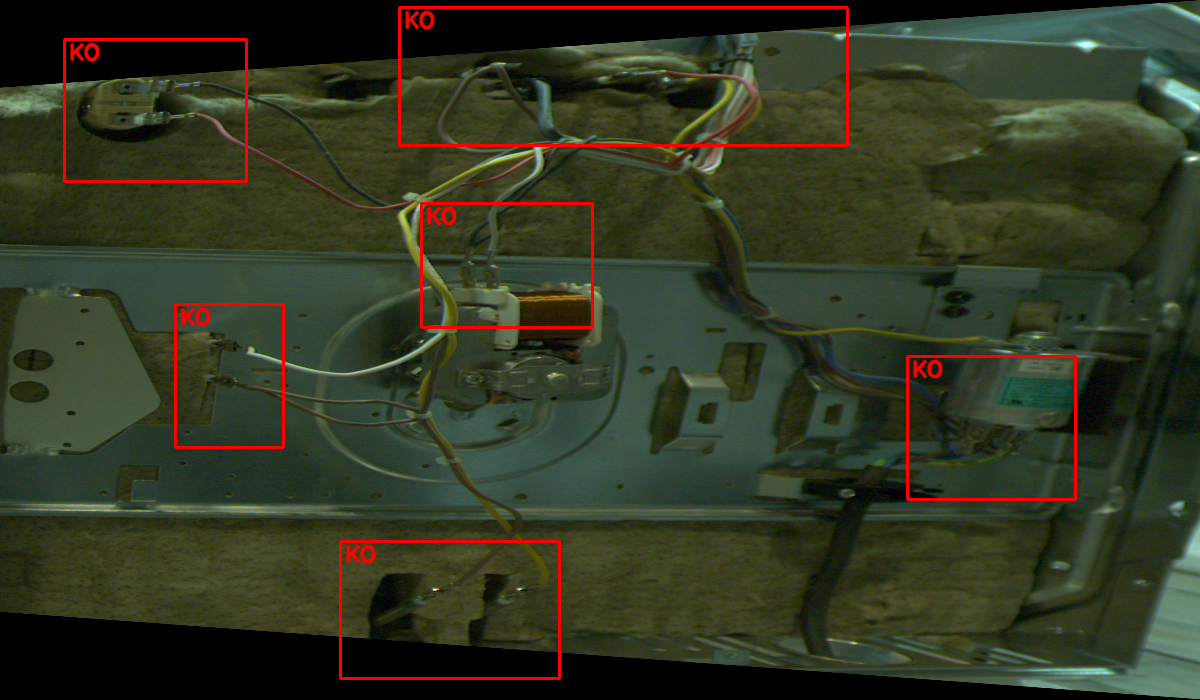

In [ ]:
import cv2
import numpy as np

# For Colab display
try:
    from google.colab.patches import cv2_imshow
except ImportError:
    def cv2_imshow(img):
        cv2.imshow("image", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# ============================
# 1. Load & warp (original warp)
# ============================

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Couldn't load the image: {path}")
    return img

def warp_back_image(image, scale=0.5):
    """
    Same warp as in your very first script:
    - add top/bottom border
    - use fixed 4 points scaled by 0.5
    - output 1200 x 700 warped image
    """
    bordered_image = cv2.copyMakeBorder(
        image,
        top=200,
        bottom=200,
        left=0,
        right=0,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )

    left_top     = np.array([290/scale,   0/scale])
    right_top    = np.array([860/scale, 100/scale])
    right_bottom = np.array([860/scale, 700/scale])
    left_bottom  = np.array([290/scale, 800/scale])

    src_points = np.array(
        [left_top, right_top, right_bottom, left_bottom],
        dtype="float32"
    )

    height = 700
    width  = 1200

    dst_points = np.array([
        [0,        0],
        [width-1,  0],
        [width-1,  height-1],
        [0,        height-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_image = cv2.warpPerspective(bordered_image, M, (width, height))
    return warped_image

# ============================
# 2. ROIs (6 components) – from your red rectangles
#     (y1, y2, x1, x2) on the warped 1200x700 image
# ============================

COMPONENT_ROIS = {
    # top-left connector
    "Component 1": (39, 181,  64, 246),
    # top wires area
    "Component 2": (7,  145, 399, 847),
    # middle motor connector
    "Component 3": (203, 327, 421, 592),
    # left plate connector
    "Component 4": (304, 447, 175, 283),
    # right-side connector block
    "Component 5": (356, 499, 907, 1075),
    # bottom connector
    "Component 6": (541, 678, 340, 559),
}

def extract_rois(warped_image):
    rois = {}
    for name, (y1, y2, x1, x2) in COMPONENT_ROIS.items():
        rois[name] = warped_image[y1:y2, x1:x2]
    return rois

# ============================
# 3. Similarity (same as your first colab script)
# ============================

def preprocess_edges(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    return edges

def edge_similarity(edges_ref, edges_test):
    e1 = edges_ref > 0
    e2 = edges_test > 0
    inter = np.logical_and(e1, e2).sum()
    union = np.logical_or(e1, e2).sum()
    if union == 0:
        return 1.0
    return inter / union

def template_similarity(roi_ref, roi_test):
    g1 = cv2.cvtColor(roi_ref, cv2.COLOR_BGR2GRAY)
    g2 = cv2.cvtColor(roi_test, cv2.COLOR_BGR2GRAY)
    res = cv2.matchTemplate(g2, g1, cv2.TM_CCOEFF_NORMED)
    return float(res[0][0])

def compare_roi(roi_ref, roi_test, alpha=0.6):
    """
    combined = alpha * template_match + (1-alpha) * edge IoU
    """
    t_sim = template_similarity(roi_ref, roi_test)
    e_sim = edge_similarity(preprocess_edges(roi_ref),
                            preprocess_edges(roi_test))
    score = alpha * t_sim + (1 - alpha) * e_sim
    return score, t_sim, e_sim

# ============================
# 4. Inspection pipeline
# ============================

def inspect_back(
    template_path,      # GOOD raw BACK image
    image_path,         # image to inspect
    combined_threshold=0.6
):
    template_raw = load_image(template_path)
    image_raw    = load_image(image_path)

    template_warped = warp_back_image(template_raw)
    test_warped     = warp_back_image(image_raw)

    template_rois = extract_rois(template_warped)
    test_rois     = extract_rois(test_warped)

    annotated = test_warped.copy()
    overall_ok = True

    print(f"Checking image: {image_path}")

    for name, (y1, y2, x1, x2) in COMPONENT_ROIS.items():
        roi_ref  = template_rois[name]
        roi_test = test_rois[name]

        score, t_sim, e_sim = compare_roi(roi_ref, roi_test)
        status = "OK" if score >= combined_threshold else "KO"
        if status == "KO":
            overall_ok = False

        print(
            f"{name}: {status} | "
            f"combined={score:.3f} (template={t_sim:.3f}, edges={e_sim:.3f})"
        )

        color = (0, 255, 0) if status == "OK" else (0, 0, 255)
        cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            annotated,
            status,
            (x1 + 5, y1 + 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
            cv2.LINE_AA
        )

    print("Overall result:", "OK" if overall_ok else "KO")
    cv2_imshow(annotated)

# ============================
# 5. Run (set your paths here)
# ============================

# 1) one GOOD sample with all connectors present (raw BACK image)
template_path = "/content/12.png"   # golden sample

# 2) image to check
image_path    = "/content/6.png"   # start by testing on same image

inspect_back(template_path, image_path)

